<a href="https://colab.research.google.com/github/TheoPantaz/Motor-Imagery-Classification-with-Tensorflow-and-MNE/blob/master/Motor_Imagery_clsf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install mne

In [ ]:
!pip install mne


     |████████████████████████████████| 6.8MB 8.3MB/s 


Import libraries

In [ ]:
import scipy.io as sio
import sklearn.preprocessing as skpr
import mne
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


Import data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

def import_from_mat(filename):
    dataset = sio.loadmat(filename, chars_as_strings = True)
    return dataset['EEG'], dataset['LABELS'].flatten(), dataset['Fs'][0][0], dataset['events'].T

filename = '/content/drive/My Drive/PANTAZ_s2'
EEG, LABELS, Fs, events = import_from_mat(filename)

Mounted at /content/drive


Normalize data

In [ ]:
def standardize(data):
    scaler = skpr.StandardScaler()
    return scaler.fit_transform(data)

EEG = standardize(EEG)

Create mne object

In [ ]:
channel_names = ['c1', 'c2', 'c3', 'c4', 'cp1', 'cp2', 'cp3', 'cp4']
channel_type = 'eeg'

def create_mne_object(EEG, channel_names, channel_type):
    info = mne.create_info(channel_names, Fs, ch_types = channel_type)
    raw = mne.io.RawArray(EEG.T, info)
    return raw

raw = create_mne_object(EEG, channel_names, channel_type)

Creating RawArray with float64 data, n_channels=8, n_times=400000
    Range : 0 ... 399999 =      0.000 ...  1599.996 secs
Ready.


filtering

In [ ]:
def filtering(raw, low_freq, high_freq):
    # Notch filtering
    freqs = (50, 100)
    raw = raw.notch_filter(freqs = freqs)

    # Apply band-pass filter
    raw.filter(low_freq, high_freq, fir_design = 'firwin', skip_by_annotation = 'edge')
    return raw
    
low_freq = 7.
high_freq = 30.
filtered = filtering(raw, low_freq, high_freq)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 sec)



Epoching the data
> IM_dur = duration of original epoch

> last_start_of_epoch : at what point(percentage) of the original epoch will the last new epoch start



In [ ]:
def Epoch_Setup(events, IM_dur, step, last_start_of_epoch): 
  IM_dur = int(IM_dur * Fs)
  step = int(step * IM_dur)
  last_start_of_epoch = int(last_start_of_epoch * IM_dur)
  print(last_start_of_epoch)
  steps_sum = int(last_start_of_epoch / step)
  new_events = [[],[],[]]

  for index in events:
    new_events[0].extend(np.arange(index[0], index[0] + last_start_of_epoch, step))
    new_events[1].extend([0] * steps_sum) 
    new_events[2].extend([index[-1]] * steps_sum) 
  new_events = np.array(new_events).T
  return new_events

def Epochs(data, events, tmin, tmax):
  epochs = mne.Epochs(data, events=events, tmin=tmin, tmax=tmax, preload=True, baseline=None, proj=True)
  epoched_data = epochs.get_data()
  labels = epochs.events[:, -1]
  return epoched_data, labels

IM_dur = 4 
step = 1/250
last_start_of_epoch = 0.5

tmix = -1
tmax = 2

new_events = Epoch_Setup(events, IM_dur, step, last_start_of_epoch)
epoched_data, labels = Epochs(filtered, new_events, tmix, tmax)

500
Not setting metadata
Not setting metadata
25000 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25000 events and 751 original time points ...
0 bad epochs dropped


Split training and testing data

In [ ]:
def data_split(data, labels, split):
  split = int(split * data.shape[0])
  X_train = epoched_data[:split]
  X_test = epoched_data[split:]
  Y_train = labels[:split]
  Y_test = labels[split:]
  return X_train, X_test, Y_train, Y_test

split = 0.5
X_train, X_test, Y_train, Y_test = data_split(epoched_data, labels, split)
print(X_train.shape)
print(Y_train.shape)

(12500, 8, 751)
(12500,)


CSP fit and transform

In [ ]:
components = 8
csp = mne.decoding.CSP(n_components=components, reg='oas', log = None, norm_trace=True)
X_train = csp.fit_transform(X_train, Y_train)
X_test = csp.transform(X_test)

Computing rank from data with rank=None
    Using tolerance 0.11 (2.2e-16 eps * 8 dim * 6.2e+13  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.087 (2.2e-16 eps * 8 dim * 4.9e+13  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using OAS
Done.


Data reshape for Tensorflow model


> Create batches for LSTM



In [ ]:
def reshape_data(X_train, X_test, labels, final_reshape):
  X_train = np.reshape(X_train, (int(X_train.shape[0]/final_reshape), final_reshape, X_train.shape[-1]))
  X_test = np.reshape(X_test, (int(X_test.shape[0]/final_reshape), final_reshape, X_test.shape[-1]))

  n_labels = []
  for i in range(0,len(labels),final_reshape):
    n_labels.append(labels[i])
  Labels = np.array(n_labels)
  Y_train = Labels[:X_train.shape[0]] - 1
  Y_test = Labels[X_train.shape[0]:] - 1
  return X_train, X_test, Y_train, Y_test

reshape_factor = int(last_start_of_epoch / step)
final_reshape = int(reshape_factor)
X_train, X_test, Y_train, Y_test = reshape_data(X_train, X_test, labels, final_reshape)  

Create tensorflow model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128,  input_shape = [None,X_train.shape[-1]], return_sequences = True),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')        
])
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(lr = 0.0001),metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 128)         70144     
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 485,057
Trainable params: 485,057
Non-trainable params: 0
________________________________________________

Model fit

In [ ]:
history = model.fit(X_train, Y_train, epochs= 50, batch_size = 25, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/50
4/4 [==============================] - 1s 182ms/step - loss: 0.6915 - accuracy: 0.5400 - val_loss: 0.6891 - val_accuracy: 0.5800
Epoch 2/50
4/4 [==============================] - 0s 35ms/step - loss: 0.6838 - accuracy: 0.6400 - val_loss: 0.6850 - val_accuracy: 0.5100
Epoch 3/50
4/4 [==============================] - 0s 27ms/step - loss: 0.6740 - accuracy: 0.6000 - val_loss: 0.6798 - val_accuracy: 0.5000
Epoch 4/50
4/4 [==============================] - 0s 24ms/step - loss: 0.6683 - accuracy: 0.6200 - val_loss: 0.6692 - val_accuracy: 0.7000
Epoch 5/50
4/4 [==============================] - 0s 19ms/step - loss: 0.6584 - accuracy: 0.7300 - val_loss: 0.6545 - val_accuracy: 0.8600
Epoch 6/50
4/4 [==============================] - 0s 19ms/step - loss: 0.6412 - accuracy: 0.7500 - val_loss: 0.6362 - val_accuracy: 0.8900
Epoch 7/50
4/4 [==============================] - 0s 20ms/step - loss: 0.6194 - accuracy: 0.7900 - val_loss: 0.6158 - val_accuracy: 0.7300
Epoch 8/50
4/4 [==========

Accuracy and plot loss

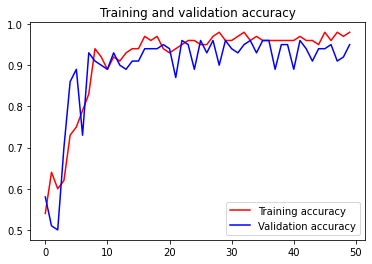

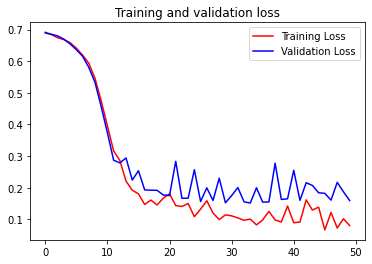

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Running classifier

Not setting metadata
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Loading data for 200 events and 1251 original time points ...
1 bad epochs dropped
4/4 [==============================] - 0s 4ms/step - loss: 0.3221 - accuracy: 0.8900


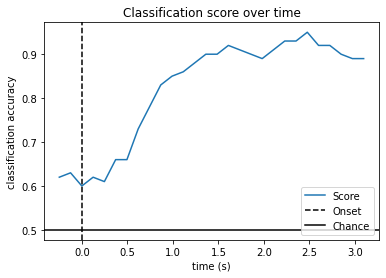

In [ ]:
tmin = -1
tmax = 4

epoched_data_running, labels_running = Epochs(filtered, events, tmix, tmax)
split = 0.5
split = int(split * epoched_data_running.shape[0])
X_test_running = epoched_data_running[split:]
Y_test_running = LABELS[split:-1] - 1

w_length = int(Fs * 1.5)   # running classifier: window length
w_step = int(Fs/250)  # running classifier: window step size
w_start = np.arange(0, X_test_running.shape[2] - w_length, w_step)
final_reshape = int(reshape_factor/4)

scores = [] 
batch_data = []
for i, n in enumerate(w_start):
  data = csp.transform(X_test_running[...,n:n+w_length])
  batch_data.append(data)
  if (i+1) % final_reshape == 0:
    batch_data = np.transpose(np.array(batch_data), (1,0,2))
    scores.append(model.evaluate(batch_data, Y_test_running))
    batch_data = []
scores = np.array(scores)
w_times = (np.arange(0, X_test_running.shape[2] - w_length, final_reshape * w_step) + w_length / 2.) / Fs + tmin
w_times = w_times[:-1]

plt.figure()
plt.plot(w_times, scores[:,1], label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()
